In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

C:\Users\fujii\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() dos Pandas. 
Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas.

In [3]:
#url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv('Titanic.csv', index_col=0)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


VARIABLE DESCRIPTIONS
Survived - Survival (0 = No; 1 = Yes);
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd);
Name - Name;
Sex - Sex;
Age - Age;
SibSp - Number of Siblings/Spouses Aboard;
Parch - Number of Parents/Children Aboard;
Ticket - Ticket Number;
Fare - Passenger Fare (British pound);
Cabin - Cabin;
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton);

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn.

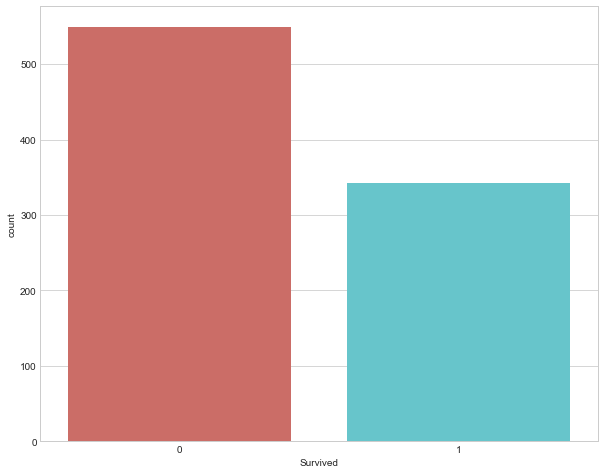

In [4]:
sb.countplot(x='Survived',data=titanic, palette='hls')

Ok, agora veja que a variavel Survived é binária

# Checking for missing values
É fácil checar missing values usando método isnull() com o método sum(), o número retornado condiz com a quantidade True para o teste, ou seja, quantidade de valores nulos nas variaveis

In [5]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 130.5+ KB


Ok, então existem 891 linhas no dataframe. Cabin é quase todo composto por missing values, então podemos eliminar essa variável completamente! Mas e quanto à idade? A age parece um preditor relevante para a sobrevivência, certo? Nós queremos manter as variáveis, mas tem 177 missing values. Precisamos encontrar uma maneira de nos aproximarmos desses valores em falta!

# Lidando com missing values
Removendo missing values
Vamos além dos missing values... Vamos descartar todas as variáveis que não são relevantes para a predição de Survived.

In [7]:
#E quanto ao nome de uma pessoa, número do bilhete e número de identificação do passageiro? Eles são irrelavantes para prever a capacidade de sobrevivência. E, como você se lembra, a variável cabine é quase todoa com missing values!!
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Agora, o dataframe foi reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável age.

# Imputing missing values
Vejamos como a idade do passageiro está relacionada à sua classe como passageiro no barco.

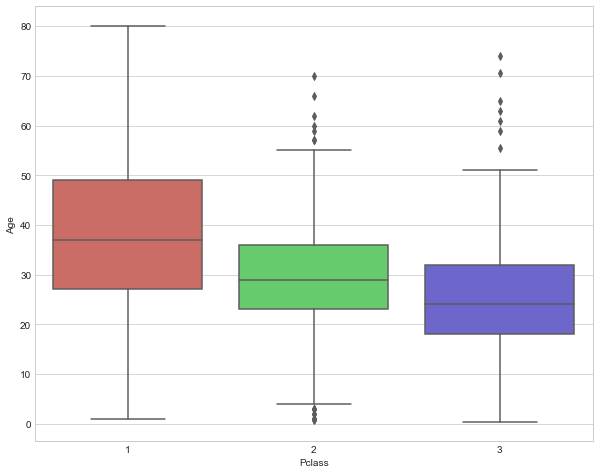

In [8]:
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

Falando mais ou menos, poderíamos dizer que quanto mais jovem é um passageiro, mais provável é que ele esteja na 3ª classe. Quanto mais velho for um passageiro, maior a probabilidade de estarem na 1ª classe. Portanto, há um relacionamento frouxo entre essas variáveis. Então, vamos escrever uma função que se aproxime da idade dos passageiros, com base em sua classe. Na caixa, parece que a idade média dos passageiros de 1ª classe é de cerca de 37 anos, os passageiros de 2ª classe são 29 e os passageiros de 3ª classe são 24.

Então, vamos escrever uma função que encontre cada valor nulo na variável Age e, para cada nulo, verifique o valor da Pclass e atribua um valor de idade de acordo com a idade média dos passageiros nessa classe.

In [9]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Após definir a função, vamos executar apenas para os valores nulos de Age

In [10]:
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Existem ainda 2 valores nulos na variável Embarked. Podemos eliminar esses dois registros sem perder muitas informações importantes do nosso conjunto de dados, então faremos isso.

In [11]:
#titanic_data.dropna(inplace=True)
#titanic_data.isnull().sum()

# Converting categorical variables to a dummy indicators

In [12]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [13]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [14]:
#Ainda não alteramos os dados! Vamos alterar em seguida.
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [15]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [16]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

X_with_null = titanic_dmy.loc[titanic_dmy['Age'].isnull()].drop(['Survived','Age'], axis=1)
print(X_with_null.head(10), X_with_null.shape)
new_data = titanic_dmy.loc[set(titanic_dmy.index) - set(X_with_null.index)].drop(['Survived'], axis=1)
print(new_data.head(10))# , new_data.shape)
y = new_data['Age']
X = new_data.drop('Age', axis=1)

reg.fit(X, y)
predicted_age = reg.predict(X_with_null)
new_age = pd.Series(predicted_age, index=X_with_null.index)
titanic_dmy.Age.loc[titanic_dmy.Age.isnull()] = predicted_age

    Pclass  SibSp  Parch      Fare  male  Q  S
5        3      0      0    8.4583     1  1  0
17       2      0      0   13.0000     1  0  1
19       3      0      0    7.2250     0  0  0
26       3      0      0    7.2250     1  0  0
28       3      0      0    7.8792     0  1  0
29       3      0      0    7.8958     1  0  1
31       1      1      0  146.5208     0  0  0
32       3      0      0    7.7500     0  1  0
36       3      0      0    7.2292     1  0  0
42       3      0      0    7.8958     1  0  0 (177, 7)
    Pclass   Age  SibSp  Parch     Fare  male  Q  S
0        3  22.0      1      0   7.2500     1  0  1
1        1  38.0      1      0  71.2833     0  0  0
2        3  26.0      0      0   7.9250     0  0  1
3        1  35.0      1      0  53.1000     0  0  1
4        3  35.0      0      0   8.0500     1  0  1
6        1  54.0      0      0  51.8625     1  0  1
7        3   2.0      3      1  21.0750     1  0  1
8        3  27.0      0      2  11.1333     0  0  1
9     

C:\Users\fujii\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
titanic_dmy.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.000000,1,0,7.2500,1,0,1
1,1,1,38.000000,1,0,71.2833,0,0,0
2,1,3,26.000000,0,0,7.9250,0,0,1
3,1,1,35.000000,1,0,53.1000,0,0,1
4,0,3,35.000000,0,0,8.0500,1,0,1
5,0,3,31.275746,0,0,8.4583,1,1,0
6,0,1,54.000000,0,0,51.8625,1,0,1
7,0,3,2.000000,3,1,21.0750,1,0,1
8,1,3,27.000000,0,2,11.1333,0,0,1
9,1,2,14.000000,1,0,30.0708,0,0,0


In [19]:
new_age

5      31.275746
17     35.489425
19     23.100970
26     26.302886
28     28.082263
29     28.321003
31     31.671301
32     28.084145
36     26.302825
42     26.293118
45     28.318758
46     27.286379
47     28.084145
48     18.318752
55     42.404541
64     40.489931
65     21.514510
76     28.321003
77     28.318758
82     28.083599
87     28.318758
95     28.318758
101    28.321003
107    28.322762
109    23.958508
121    28.318758
126    31.286060
128    18.209027
140    21.414674
154    28.329497
         ...    
718    31.173210
727    28.084327
732    35.678722
738    28.321003
739    28.321003
740    42.484628
760    28.224837
766    40.316954
768    27.160424
773    26.302886
776    31.286060
778    31.286242
783    22.638180
790    31.286060
792    -8.442829
793    40.446611
815    42.921467
825    31.297709
826    27.613323
828    31.286060
832    26.302825
837    28.318758
839    40.461111
846    -5.240913
849    32.507362
859    26.302825
863    -8.442829
868    28.2976

In [20]:
scaler = StandardScaler()
#titanic_dmy.Age = scaler.fit_transform(titanic_dmy)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Agora temos um conjunto de dados com todas as variáveis no formato correto!

# Validando independencia entre as variáveis

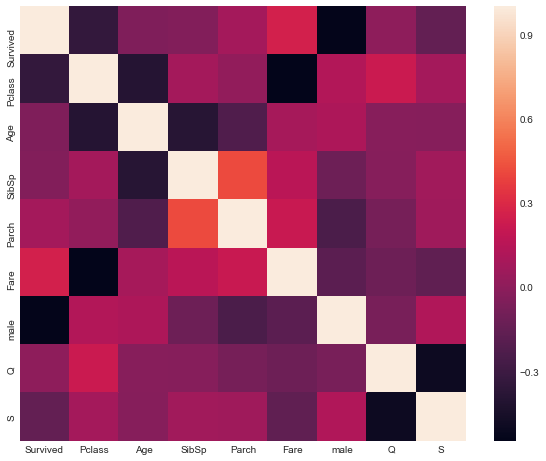

In [21]:
sb.heatmap(titanic_dmy.corr())  

Fare e Pclass não sao independentes uma com a outra, entao vou excluí-las.

In [22]:
titanic_dmy.drop(['Fare'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S
0,0,3,22.0,1,0,1,0,1
1,1,1,38.0,1,0,0,0,0
2,1,3,26.0,0,0,0,0,1
3,1,1,35.0,1,0,0,0,1
4,0,3,35.0,0,0,1,0,1


# Agora vamos lá!!
1º: Separar o conjunto em variavel resposta e variaveis de treinamento

In [23]:
scaler = StandardScaler()
X = titanic_dmy.iloc[:,[1,2,3,4,5,6,7]]
y = titanic_dmy.iloc[:,0]

Agora dividir em treino e teste (teste com 30%)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state=15)

# Criando o modelo

In [25]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Testando o modelo

In [26]:
y_pred = LogReg.predict(X_test)

# Avaliando o modelo
analisando o rotulo real com o rotulo predito

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[226,  27],
       [ 58, 135]], dtype=int64)

In [28]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.89      0.84       253
          1       0.83      0.70      0.76       193

avg / total       0.81      0.81      0.81       446



In [29]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.83      0.82       253
          1       0.77      0.76      0.76       193

avg / total       0.80      0.80      0.80       446



In [30]:
from sklearn.neighbors import KNeighborsClassifier


list_ = np.arange(5, 100, 5)

best_score = 0
best_k = 0

for k in list_:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    score_ = clf.score(X_test, y_test)
    
    if score_ > best_score:
        best_score = score_
        best_k = k
    
print(best_score, best_k)
    

0.757847533632287 5


In [31]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.83      0.81       253
          1       0.76      0.71      0.73       193

avg / total       0.78      0.78      0.78       446



In [32]:
from sklearn.svm import SVC

svc_clf = SVC(C=15, gamma=1e-2)
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.89      0.85       253
          1       0.83      0.75      0.79       193

avg / total       0.83      0.83      0.82       446



In [33]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

loo = LeaveOneOut()
loo.get_n_splits(X)

ac_train = []
ac_test = []
for train_index, test_index in loo.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #print(X_train, X_test, y_train, y_test)
    classificator = SVC(C=15, gamma=1e-2)
    classificator_trained = classificator.fit(X_train, y_train)
    ac_train.extend([accuracy_score(classificator_trained.predict(X_train), y_train)])
    ac_test.extend([accuracy_score(classificator_trained.predict(X_test), y_test)])

print('acurácia média treino', np.mean(ac_train))
print('acurácia média test', np.mean(ac_test)) 

acurácia média treino 0.8293975964387953
acurácia média test 0.8260381593714927


In [34]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)
print(kf)  

from sklearn import linear_model
ac_train = []
ac_test = []

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    classificator = SVC(C=15, gamma=1e-2)
    classificator_trained = classificator.fit(X_train, y_train)
    ac_train.extend([accuracy_score(classificator_trained.predict(X_train), y_train)]) 
    ac_test.extend([accuracy_score(classificator_trained.predict(X_test), y_test)])
    #classificator_trained.score(X_train, y_train)

print('acurácia média treino', np.mean(ac_train))
print('acurácia média test', np.mean(ac_test))

KFold(n_splits=10, random_state=None, shuffle=False)
acurácia média treino 0.8291558868123075
acurácia média test 0.8271660424469414


In [75]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(6), activation='logistic', random_state=42, 
                    learning_rate_init=1e-2, learning_rate='constant')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.86      0.83        56
          1       0.73      0.67      0.70        33

avg / total       0.78      0.79      0.78        89

